In [687]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal as sig

### Gaussian Smoothing 

In [688]:
################################
def func(x,y,sd):
    return np.exp(-(x**2 + y**2)/float(2*sd**2))

def change_coor(x,y):
    x = -1*x + 4
    y -= 4
    return y,x

def norm(mat):
    total = sum(sum(mat))
    return mat/total
#################################
def gaussian(sd):
    G = np.zeros((9,9))
    for x in range(G.shape[0]):
        for y in range(G.shape[1]):
            x,y = change_coor(x,y)
            G[x][y] = func(x,y,sd)
    
    normed_matrix = norm(G)
    return normed_matrix

In [689]:
img = cv2.imread('../lenna.jpeg', 0)
blurred_img = ndimage.filters.convolve(img,gaussian(1)) #Gaussian Blur

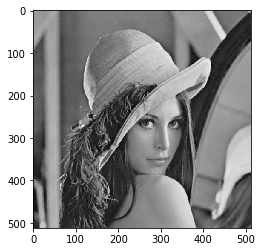

In [703]:
plt.imshow(img, cmap='gray')
plt.savefig('lenna_orig.png')

### Sobel Operators

In [691]:
K_X = np.matrix([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
K_Y = np.matrix([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [692]:
I_X = sig.convolve2d(blurred_img, K_X,mode='same')
I_Y = sig.convolve2d(blurred_img, K_Y,mode='same')

In [693]:
G = np.hypot(I_X, I_Y) #Generating gradient magnitude
G = G*255/G.max()
G = G.astype('uint8')

In [694]:
theta = np.arctan2(I_Y, I_X) #Generating gradient direction

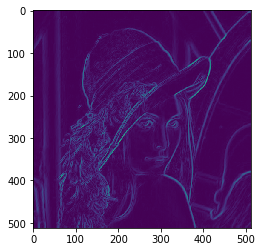

In [695]:
plt.imshow(G)

### Non-Maximum Suppression

In [696]:
angle = theta*180/np.pi
angle[angle < 0] += 180

M, N = G.shape
output = np.zeros(G.shape, dtype=np.int32)

for i in range(1,M-1):
    for j in range(1,N-1):
        direction = angle[i,j]

        if (0 <= direction < 180/8) or (7*180/8 <= direction <= 180): #angle0
            side1 = G[i, j+1]
            side2 = G[i, j-1]
            
        elif (180/8 <= direction < 3*180/8): #angle45
            side1 = G[i+1, j-1]
            side2 = G[i-1, j+1]
            
        elif (3*180/8 <= direction < 5*180/8): #angle90
            side1 = G[i+1, j]
            side2 = G[i-1, j]
            
        else: #angle135
            side1 = G[i-1, j-1]
            side2 = G[i+1, j+1]

        if (G[i,j] >= side1) and (G[i,j] >= side2):
            output[i,j] = G[i,j]
        else:
            output[i,j] = 0

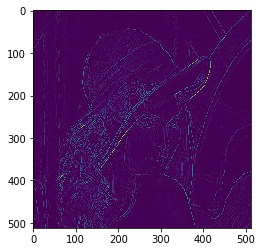

In [697]:
plt.imshow(output)

### Double Threshold

In [698]:
high = 0.2 #High Level
low = 0.15

cat_Z = np.zeros(output.shape)

thresh_high = high*output.max()
thresh_low = low*thresh_high

for i in range(M):
    for j in range(N):
        if output[i,j] > thresh_high:
            cat_Z[i,j] = 255

        elif output[i,j] > thresh_low:
            cat_Z[i,j] = 1

In [699]:
weak = 1
strong = 255

M, N = cat_Z.shape  
for i in range(1, M-1):
    for j in range(1, N-1):
        
        if (cat_Z[i,j] == weak):
            try:
                if strong in [cat_Z[i+1, j-1], cat_Z[i+1, j], cat_Z[i+1, j+1], cat_Z[i, j-1], cat_Z[i, j+1], cat_Z[i-1, j-1], cat_Z[i-1, j], cat_Z[i-1, j+1]]:
                    cat_Z[i, j] = strong
                else:
                    cat_Z[i, j] = 0
            except:
                pass

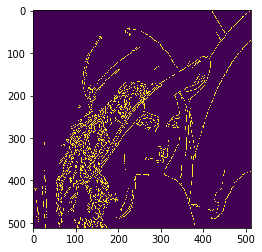

In [701]:
plt.imshow(cat_Z)
plt.savefig('lenna_mycode.png')

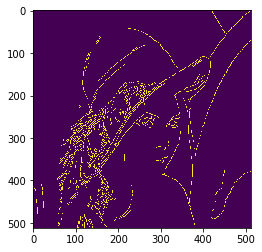

In [702]:
# Compare with Canny
plt.imshow(cv2.Canny(blurred_img,100,200))
plt.savefig('lenna_cv2.png')